### Phase fraction uncertainty quantification

For a given phase, define the normalized intensities as

$$Z_i = I_i / R_i$$

For now, we'll assume the $R_i$ are known completely while we figure out how to implement them efficiently in GSAS. (Either way this is likely a small component of uncertainty relative to the experimental variability of the $I_i$'s.)

There is uncertainty in the $I_i$'s both due to experimental set up as well as the fitting procedure. We'll assume these sources of uncertainty are independent, and thus additive. Thus we model

$$
I_i \sim N(\mu_I, \sigma_{I,exp}^2 + \sigma_{fit_i}^2)
$$

and so 

$$
Z_i \sim N\big(\mu_z, \sigma_{Z,exp}^2 + \frac{\sigma_{fit_i}^2}{R_i^{2}} \big)
$$

$\sigma^2_{fit_i}$ will be assumed known from the fitting procedure, while $\sigma^2_{Z,exp}$ will have to be estimated from data. Since we won't estimate $\mu_I$ and $\sigma^2_{I,exp}$ directly, we will simply denote $\mu_Z$ and $\sigma_Z$ as $\mu$ and $\sigma$ respectively.

In the Bayesian framework, we can write

\begin{align}
p(\mu, \sigma^2_{exp} | Z_i) &\propto p(Z_i|\mu, \sigma^2_{exp}) p(\mu, \sigma^2_{exp}) \\
&= N(Z_i,\mu,\sigma^2_{exp} + R_i^{-2}\sigma^2_{fit}) p(\mu,\sigma^2_{exp})
\end{align}

where the prior distributions will be a standard choice such as a truncated $t_4$ scaled to the MAD. 

Estimation for the other phases will follow similarly.

### Example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
from scipy.stats import median_abs_deviation as mad


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(az.__version__)
print(pm.__version__)

0.11.2
3.6


In [3]:
mydf = pd.DataFrame({
    'I':np.random.normal(np.repeat([100,150],6),10 ),
    'R':np.random.normal(50,10,12),
    'sigma_I':np.ones(12)/10,
    'phases':np.repeat([0,1],6)
})

In [4]:
print(mydf)

             I          R  sigma_I  phases
0   101.495589  49.601761      0.1       0
1   113.823691  38.251337      0.1       0
2   109.570527  49.020491      0.1       0
3    87.862795  24.492870      0.1       0
4    97.579111  50.252694      0.1       0
5    90.246517  65.071657      0.1       0
6   143.387370  36.878045      0.1       1
7   148.204596  32.010922      0.1       1
8   152.200231  48.994337      0.1       1
9   130.607658  55.794908      0.1       1
10  160.336019  34.381130      0.1       1
11  140.670858  67.611590      0.1       1


In [8]:
def run_mcmc(I,R,sigma_I,phases,plot=False):

    I = np.array(I)
    R = np.array(R)
    sigma_I = np.array(sigma_I)
    phases = np.array(phases)
    phase_names = phases.copy()

    Z = I/R
    unique_phase_names = np.unique(phase_names)

    phases = np.zeros(len(phases),dtype=np.int8)
    
    for ii in range(len(unique_phase_names)):

        phases[phase_names==unique_phase_names[ii]] = int(ii)

    unique_phases = np.unique(phases)
    phase_stds = np.zeros(len(unique_phases))


    for ii in range(len(unique_phases)):

        phase_stds[ii] = np.std(Z[phases==unique_phases[ii]])

    prior_scale=np.mean(phase_stds)
    prior_mean_centers = np.ones(len(unique_phases))

    print(prior_scale)
    print(prior_mean_centers)   

    if plot:
        plt.plot(np.arange(6),Z[0:6],'bo')
        plt.axhline(y=np.mean(Z[0:6]),color='blue')
        plt.plot(np.arange(6),Z[6:12],'ro')
        plt.axhline(y=np.mean(Z[6:12]),color='red')
        plt.show()

    basic_model = pm.Model() 

    with basic_model:
        
        # Priors for unknown model parameters
        sigma_exp = pm.HalfStudentT("sigma_exp", sd=prior_scale*3, nu=4,shape=1)
        mu = pm.Normal("mu", 
                       mu=prior_mean_centers, 
                       sd=prior_scale*3,
                       shape=len(unique_phases))
        
        full_sigma = pm.math.sqrt( (1/R**2)*(sigma_I**2 + pm.math.sqr(sigma_exp) ))

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu[phases], sd=full_sigma, observed=Z)

        if plot:
            pm.model_to_graphviz(basic_model)

        trace = pm.sample(500, return_inferencedata=False,tune=1000)

    return trace, basic_model

    

0.8721570722128442
[1. 1.]


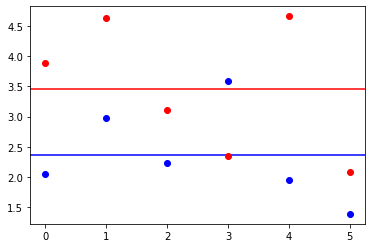

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_exp]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1406.11draws/s]


In [9]:
res, basic_model = run_mcmc(mydf.I,mydf.R,mydf.sigma_I,mydf.phases,plot=True)

In [10]:
print(type(res.varnames))
print(type(res['mu']))
print(res['mu'].shape)

<class 'list'>
<class 'numpy.ndarray'>
(2000, 2)


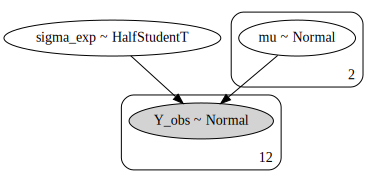

In [11]:
pm.model_to_graphviz(basic_model)

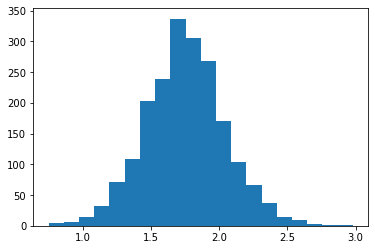

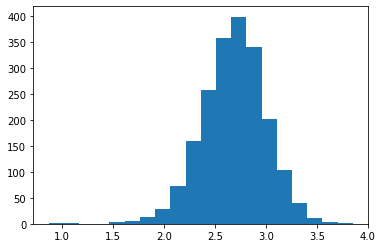

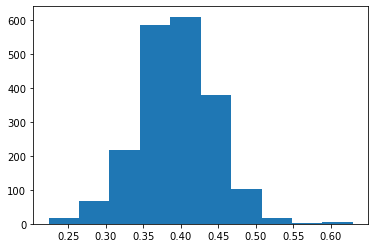

In [36]:
plt.hist(res['mu'][:,0],bins=20)
plt.show()
plt.hist(res['mu'][:,1],bins=20)
plt.show()
plt.hist(res['mu'][:,0]/(res['mu'][:,0] + res['mu'][:,1]))
plt.show()

(array([  7.,  10.,  42.,  69., 110., 167., 223., 219., 229., 168., 175.,
        143., 111.,  75.,  61.,  55.,  36.,  26.,  15.,  12.,  13.,   6.,
          7.,   3.,   5.,   4.,   2.,   3.,   0.,   4.]),
 array([ 8.74916695,  9.51390148, 10.27863601, 11.04337055, 11.80810508,
        12.57283961, 13.33757415, 14.10230868, 14.86704321, 15.63177775,
        16.39651228, 17.16124681, 17.92598135, 18.69071588, 19.45545041,
        20.22018495, 20.98491948, 21.74965401, 22.51438855, 23.27912308,
        24.04385761, 24.80859215, 25.57332668, 26.33806121, 27.10279575,
        27.86753028, 28.63226481, 29.39699935, 30.16173388, 30.92646841,
        31.69120295]),
 <BarContainer object of 30 artists>)

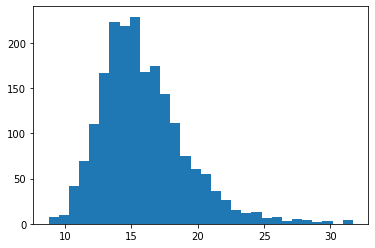

In [168]:
plt.hist(trace['sigma_exp'],bins=30)